In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [5]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [6]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

# qrels = qrels[['RTS212', 'RTS48']]

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [7]:
point = pd.read_csv(
    'eval/RTS17/gundog/ngram-length(3)_keep-spam(0)_language(en)_extract-retweets(0)'
    '_keep-retweets(1)_negative-distance-threshold(0.8).point',
    names=[
        'Topic', 'tweet_id',
        'Distance to query',
        'Distance to positive', 'Distance to negative',
        'Score',
        'retrieve', 'Positive', 'Negative',
        'Time',
    ],
    header=None,
    parse_dates=True,
    low_memory=False,
).dropna()

point.sort_values(by=['Time', 'tweet_id', 'Topic'], inplace=True)

point.drop_duplicates(subset=['tweet_id', 'Topic'], inplace=True)
point.set_index(['Time', 'tweet_id', 'Topic'], inplace=True)

point = point.unstack('Topic')

# point = pd.concat([point], axis=1, keys=['Point'])

point = point.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)

point.columns.names = 'Variable', 'Topic'

point.size

# point.head()

144704268

In [8]:
topics = list(point['Relevance'].apply(lambda c: c.value_counts()).dropna(axis='columns', how='all').columns.values)
len(topics)

96

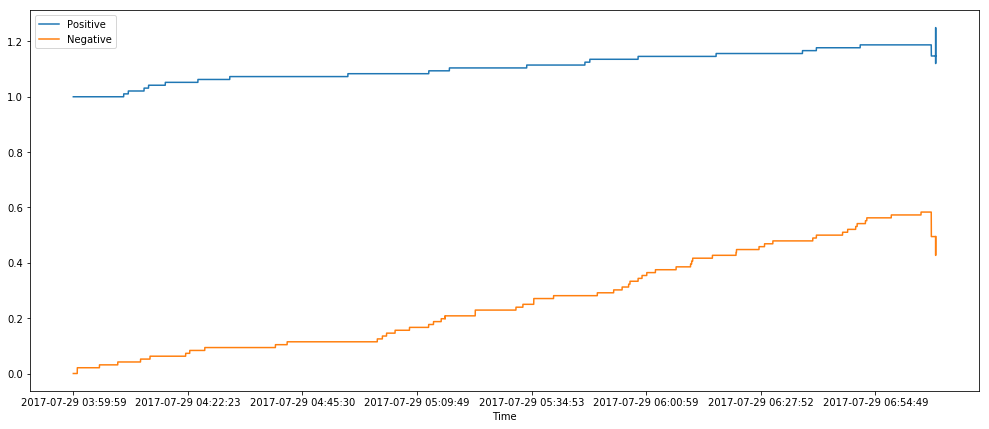

In [9]:
ax = (
    pd.DataFrame(
        {
            'Positive': point['Positive'].mean(axis='columns'),
            'Negative': point['Negative'].mean(axis='columns'),
        }
    )[['Positive', 'Negative']]
    .reset_index('tweet_id', drop=True)
#     .rolling(2_000).mean()
    .plot(figsize=(17, 7),)
)

ax.figure.savefig('eval/RTS17/plots/feedback.pdf')

In [10]:
point['Distance to query'].stack().corr(point['Score'].stack(), method='spearman')

0.92068740362043289

In [11]:
point['Score'].rank().corrwith(point['Distance to query'].rank()).sort_values(ascending=True).mean()

0.95488549584639981

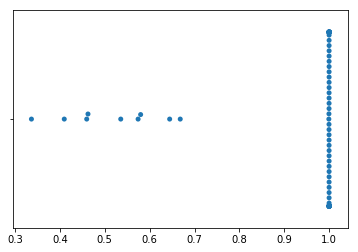

In [12]:
sns.swarmplot(
    point['Score'].rank().corrwith(point['Distance to query'].rank()).sort_values(ascending=False)
)

In [26]:
distance_score = (
    point[['Distance to query', 'Score', 'Relevance', 'retrieve']]
    .stack(['Topic'])
    .set_index(['retrieve'] , append=True)
    .dropna(subset=['Relevance'])
    .set_index('Relevance', append=True)
    .stack().to_frame('Value')
    .reset_index()
    .set_index(['Topic', 'tweet_id'])
)
distance_score = distance_score[distance_score['Relevance'] >= 0]
distance_score['Relevance'] = distance_score['Relevance'] > 0

distance_score.loc[distance_score['Relevance'] > 0, 'Relevance'] = 'Relevant'
distance_score.loc[distance_score['Relevance'] == 0, 'Relevance'] = 'Non-relevant'

distance_score['Error'] = distance_score.apply(
    lambda r: {
        ('Relevant', True): 'TP',
        ('Relevant', False): 'FN',
        ('Non-relevant', True): 'FP',
        ('Non-relevant', False): 'TN',
    }[r['Relevance'], r['retrieve'] if r['Variable'] == 'Score' else r['Value'] < 0.8],
    axis='columns',
)

/home/dnm11/miniconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


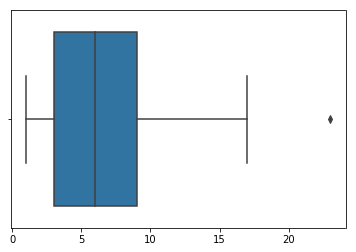

In [27]:
sns.boxplot(
    distance_score.reset_index().set_index('Variable')
    .loc['Score', ['Topic', 'Relevance']]
    .reset_index()
    .groupby(['Topic', 'Relevance'])
    .size(),
#     .unstack('Topic')
    dodge=True,
);

In [28]:
!mkdir -p eval/RTS17/plots/

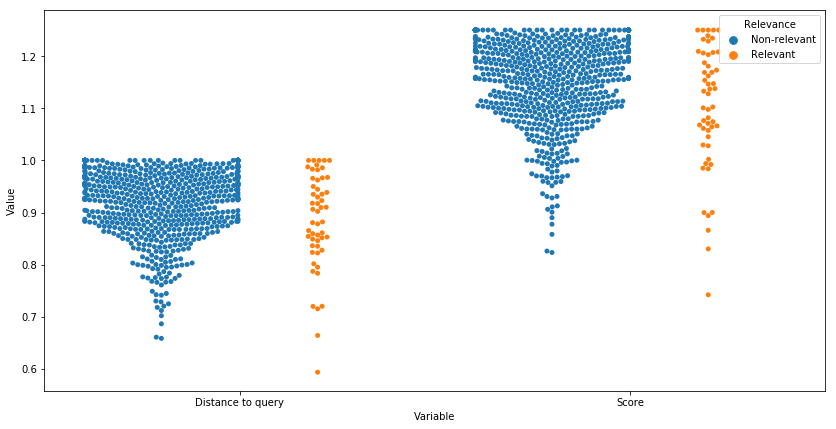

In [29]:
f, ax = plt.subplots(figsize=(14, 7))

sns.swarmplot(
    data=distance_score, x='Variable', y='Value',
    hue='Relevance', hue_order=['Non-relevant', 'Relevant'], dodge=True,
    ax=ax,
);

f.savefig('eval/RTS17/plots/distance-score-comparison.pdf')

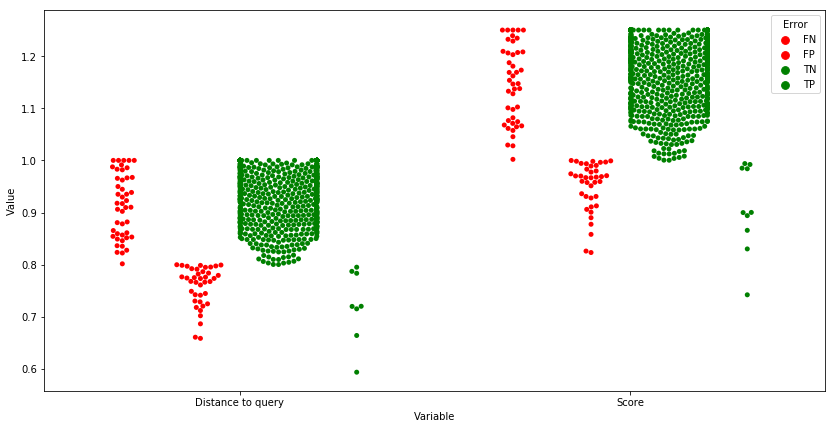

In [32]:
f, ax = plt.subplots(figsize=(14, 7))

sns.swarmplot(
    data=distance_score, x='Variable', y='Value', hue='Error',
    hue_order=[
        'FN', 'FP', 'TN', 'TP',
    ],
    palette={
        'FN': 'r',
        'TN': 'g',
        'FP': 'r',
        'TP': 'g',
        'N': 'r',
        'P': 'g',
    },
    dodge=True,
    ax=ax,
);

f.savefig('eval/RTS17/plots/distance-score-comparison-error-type.pdf')

# Sandbox

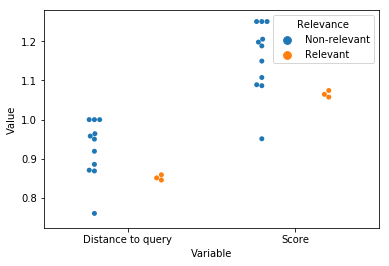

In [19]:
sns.swarmplot(
    data=distance_score.loc['RTS212'], x='Variable', y='Value',
    hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
    dodge=True,
);

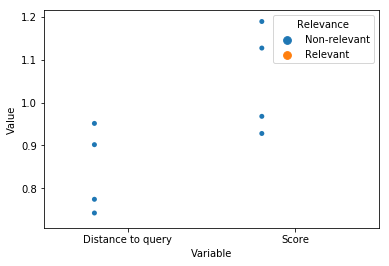

In [20]:
sns.swarmplot(
    data=distance_score.loc['RTS48'], x='Variable', y='Value',
    hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
    dodge=True,
);

In [21]:
# point[['Distance to query', 'Score']].cummin().plot(use_index=False);

In [22]:
# point[['Distance to query', 'Score']].rolling(1_000_000, min_periods=1).min().plot(use_index=False);

In [23]:
# (
#     (
#         point['Positive']
#         - point['Negative']
#     )
#     .reset_index('tweet_id', drop=True)
#     [topics].plot(
#         title='Difference betweet positive and negative feedback per topic',
#         figsize=(17, 7),
#     )
# );

In [24]:
# (
#     point['Distance to query'][topics]
#     .apply(np.vectorize(lambda v: v if v < 0.8 else None)).dropna(how='all')
#     .plot(style='o', use_index=False, figsize=(14, 6))
# );

In [25]:
point.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:5]

Variable                         Distance to query                          \
Topic                                       RTS101 RTS104 RTS105    RTS106   
Time                tweet_id                                                 
2017-07-29 04:40:51 8.911565e+17          0.960384    1.0    1.0  1.000000   
2017-07-29 05:35:14 8.911702e+17          0.976348    1.0    1.0  0.965307   
2017-07-29 04:39:43 8.911563e+17          1.000000    1.0    1.0  1.000000   
2017-07-29 06:50:04 8.911891e+17          0.971275    1.0    1.0  1.000000   
2017-07-29 04:05:39 8.911477e+17          0.985698    1.0    1.0  1.000000   

Variable                                                                  \
Topic                               RTS111    RTS113    RTS114    RTS115   
Time                tweet_id                                               
2017-07-29 04:40:51 8.911565e+17  1.000000  0.985216  0.955493  0.994661   
2017-07-29 05:35:14 8.911702e+17  0.978205  0.983650  0.905432  0.993695   
2017-07-29 04:39:43 8.911563e+17  1.000000  1.000000  1.000000  1.000000   
2017-07-29 06:50:04 8.911891e+17  1.000000  0.986349  0.941577  1.000000   
2017-07-29 04:05:39 8.911477e+17  1.000000  1.000000  0.979116  1.000000   

Variable                                              ...  Relevance        \
Topic                               RTS116    RTS118  ...      RTS79 RTS82   
Time                tweet_id                          ...                    
2017-07-29 04:40:51 8.911565e+17  0.909888  0.985095  ...        NaN   NaN   
2017-07-29 05:35:14 8.911702e+17  0.883137  1.000000  ...        NaN   NaN   
2017-07-29 04:39:43 8.911563e+17  1.000000  1.000000  ...        NaN   NaN   
2017-07-29 06:50:04 8.911891e+17  0.978049  0.979564  ...        NaN   NaN   
2017-07-29 04:05:39 8.911477e+17  0.990482  1.000000  ...        NaN   NaN   

Variable                                                                    \
Topic                            RTS83 RTS87 RTS90 RTS91 RTS94 RTS96 RTS98   
Time                tweet_id                                                 
2017-07-29 04:40:51 8.911565e+17   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2017-07-29 05:35:14 8.911702e+17   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2017-07-29 04:39:43 8.911563e+17   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2017-07-29 06:50:04 8.911891e+17   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2017-07-29 04:05:39 8.911477e+17   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

Variable                                
Topic                            RTS99  
Time                tweet_id            
2017-07-29 04:40:51 8.911565e+17   NaN  
2017-07-29 05:35:14 8.911702e+17   NaN  
2017-07-29 04:39:43 8.911563e+17   NaN  
2017-07-29 06:50:04 8.911891e+17   NaN  
2017-07-29 04:05:39 8.911477e+17   NaN  

[5 rows x 769 columns]